# Práctica 1: Análisis y modelado del campo de velocidad del gas en galaxias cercanas

$\textbf{JUAN ANTONIO MOLINA CALZADA}$

In [27]:
# Packages
from astropy.table import Table
from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import megaradrp.datamodel as dm
import numpy as np
import lmfit
from operator import attrgetter
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.special import kn,iv

# Parámetros a predefinir
G = 1/232 # units = solar_mass^{-1} * pc * km²/s²

## 1. I[L$_{\odot}/pc^2$] / $\mu[mag/arcsec^2]$ vs (r[pc])

En primer lugar, vamos leer los datos .tbl (tabla de datos) para cada banda: _g_, _i_ e _i_. En cada tabla de datos encontraremos varias columnas donde se da el valor de diferentes parámetros a diferentes radios, en concreto, la columna _sma_ nos dará el valor del semi-eje mayor en píxeles. El resto de columnas nos dará el valor de un parámetro a ese radio, así por ejemplo, _intens_ nos dará el valor de la intensidad en cuentas por pixel al cuadrado para los diferentes radios. Nótese que la primera fila se corresponde con el centro de la galaxia (radio = 0) y este va aumentando conforme aumentan las filas. Trabajaremos en primer lugar con la banda R.

### 1.1. Banda r

A partir de la columna _sma_ , que nos da el valor del semi-eje mayor en arcsec, podremos obtener el radio en kpc, $r[kpc]$, como: 

$$
\begin{equation}
    r[kpc] = sma[pixel] \cdot 0.25[arcsec/pixel] \cdot 0.169[kpc/arcsec]
\end{equation}
$$

donde 0.169 es un valor tabulado (sacado de _Chamorro-Cazorla_et_al_2022.pdf_ ) para hacer la conversión de arcsec a kpc (0.169 tiene unidades de kpc/arcsec).

Por otro lado, utilizando la columna de _intens_, intensidad en cuentas por píxel al cuadrado, podremos calcular el brillo superficial $\mu(AB)$ y el brillo $I[L_{\odot}/pc^2]$ utilizando las ecuaciones 1.12 y 1.13 del guión de la práctica. En estas ecuaciones se necesita conocer los tiempos de exposición para cada banda, los cuales se encuentran en los headers de _NGC2543_panstarrs_X.fits_, siendo _X_ la banda. En la siguiente celda (raw) ponemos un ejemplo de como acceder a estos headers.

In [2]:
# Read data: band r
data_r = Table.read('Datos/NGC2543_r.tbl', format = 'ascii', delimiter = ' ')
data_r

# Round data from each column
for colname in data_r.colnames:
    if data_r[colname].dtype.kind in 'ufS':
        data_r[colname].format = '{:.3f}'

# Print data
data_r[:5]

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
float64,float64,float64,float64,float64,float64,float64,float64,str18,str20,float64,float64,float64,float64,int64,int64,int64,int64
0.000,42474.960,0.000,0.000,0.000,0.000,0.000,0.000,None,None,120.014,0.000,121.229,0.000,1,0,0,0
0.535,42158.435,16.561,0.574,0.057,90.523,4.127,-822.741,484.618547936051,0.5890294699132753,120.014,0.016,121.229,0.036,13,0,10,0
0.588,42113.888,18.359,0.571,0.057,90.655,4.168,-828.972,488.74476127301006,0.5895790816219287,120.015,0.017,121.250,0.039,13,0,10,0
0.647,42063.034,20.352,0.567,0.058,90.838,4.212,-837.784,492.42622241768413,0.5877719671029705,120.016,0.019,121.273,0.042,13,0,10,0
0.712,41998.797,22.724,0.553,0.048,91.474,3.585,-1045.554,445.1014068768061,0.4257088288312549,120.019,0.018,121.294,0.039,13,0,10,0


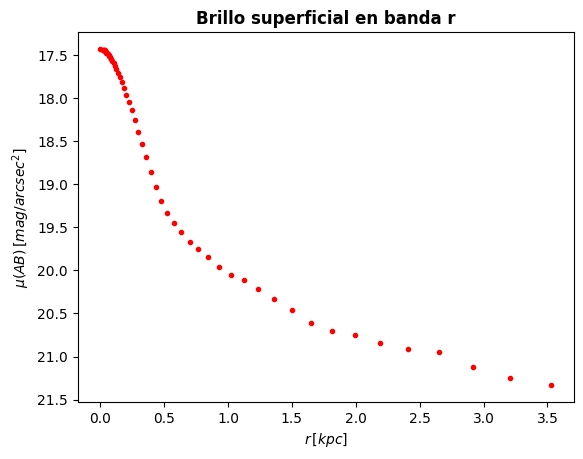

In [3]:
# Parámetros sma (semi-eje mayor en arcsec) e intens ((cuentas/pixel)^2)
sma_r = data_r['sma']
intens_r = data_r['intens']
t_exp_r = 636 # sacada del header NGC2543_panstarrs_r.fits
px_arcsec = 1 / 0.25 # sacado del guión

# Radio en pc
r_r = sma_r * 0.25 * 0.169 * 1000 #( * 1000 para pasar a pc)
u_AB_r = -2.5 * np.log10(intens_r * (px_arcsec)**2) + 2.5 * np.log10(t_exp_r) + 25

# Plot BRILLO SUPERFICIAL - banda r
plt.plot(r_r/1e3, u_AB_r, '.', color = 'red') # entre 1e3 para pasarlo a kpc
plt.title('Brillo superficial en banda r', fontweight = 'bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$\mu(AB)\,[mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.savefig('Images/brillo_superficial_banda_r.png')
plt.show()

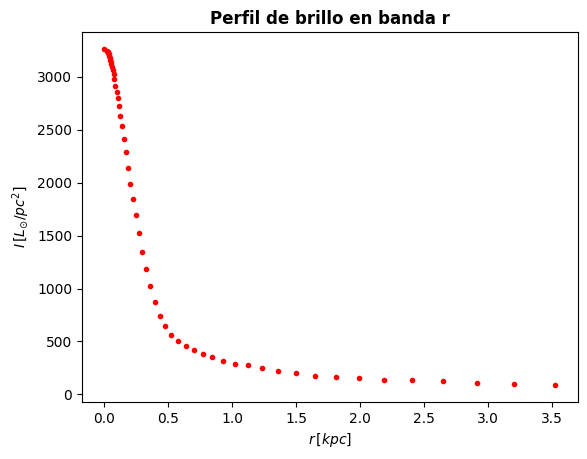

In [4]:
# Intensidad (luminosidad solar por pc cuadrado)
M_r = 4.64
I_r = 10 ** (- (u_AB_r - M_r - 21.572)/ 2.5)

# Plot PERFIL DE BRILLO - banda r
plt.plot(r_r/1e3, I_r, '.', color = 'red') # entre 1e3 para pasarlo a kpc
plt.title('Perfil de brillo en banda r', fontweight='bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$I\\,[L_{{\\odot}}/pc^2]$')
plt.savefig('Images/perfil_brillo_banda_r.png')
plt.show()

### 1.2. Banda i

Repetimos el mismo procedimiento pero ahora para la banda i.

In [5]:
# Read data: band i
data_i = Table.read('Datos/NGC2543_i.tbl', format = 'ascii', delimiter = ' ')
data_i

# Round data from each column
for colname in data_i.colnames:
    if data_i[colname].dtype.kind in 'ufS':
        data_i[colname].format = '{:.3f}'

# Print data
data_i[:5]

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
float64,float64,float64,float64,float64,float64,float64,float64,str18,str20,float64,float64,float64,float64,int64,int64,int64,int64
0.000,202177.432,0.000,0.000,0.000,0.000,0.000,0.000,None,None,119.915,0.000,121.273,0.000,1,0,0,0
0.535,201296.734,65.492,0.601,0.049,94.938,3.458,-3539.748,1912.0909907117932,0.5401770912389585,119.915,0.014,121.273,0.033,13,0,10,0
0.588,201162.786,68.754,0.605,0.047,95.701,3.301,-3481.564,1830.838195511606,0.525866664102376,119.904,0.015,121.303,0.035,13,0,10,0
0.647,201047.640,69.245,0.613,0.036,97.358,2.521,-4042.487,1702.9756503652375,0.42126932754150487,119.888,0.013,121.343,0.030,13,0,14,0
0.712,200266.840,67.598,0.451,0.030,103.317,2.520,-6202.116,2059.295433298411,0.33203112265029144,119.826,0.012,121.387,0.019,13,0,15,0


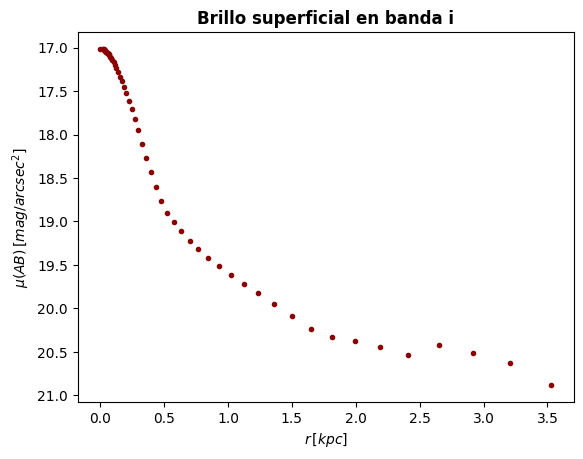

In [6]:
# Parámetros sma (semi-eje mayor en arcsec) e intens ((cuentas/pixel)^2)
sma_i = data_i['sma']
intens_i = data_i['intens']
t_exp_i = 2070 # sacada del header NGC2543_panstarrs_i.fits
px_arcsec = 1 / 0.25 # sacado del guión

# Radio en pc
r_i = sma_i * 0.25 * 0.169 * 1000 #( * 1000 para pasar a pc)
u_AB_i = -2.5 * np.log10(intens_i * (px_arcsec)**2) + 2.5 * np.log10(t_exp_i) + 25

# Plot BRILLO SUPERFICIAL - banda i
plt.plot(r_i/1e3, u_AB_i, '.', color = 'darkred') # entre 1e3 para pasarlo a kpc
plt.title('Brillo superficial en banda i', fontweight = 'bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$\mu(AB)\,[mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.savefig('Images/brillo_superficial_banda_i.png')
plt.show()

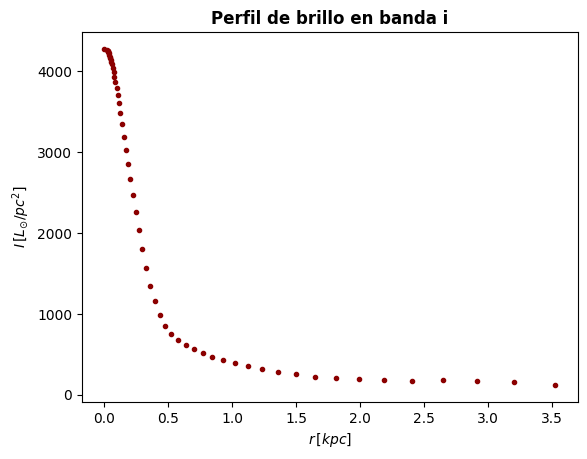

In [7]:
# Intensidad (luminosidad solar por pc cuadrado)
M_i = 4.52
I_i = 10 ** (- (u_AB_i - M_i - 21.572)/ 2.5)

# Plot PERFIL DE BRILLO - banda i
plt.plot(r_i/1e3, I_i, '.', color = 'darkred') # entre 1e3 para pasarlo a kpc
plt.title('Perfil de brillo en banda i', fontweight='bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$I\\,[L_{{\\odot}}/pc^2]$')
plt.savefig('Images/perfil_brillo_banda_i.png')
plt.show()

### 1.3. Banda g

Mismo proceso apra la banda g.

In [8]:
# Read data: band r
data_g = Table.read('Datos/NGC2543_g.tbl', format = 'ascii', delimiter = ' ')
data_g

# Round data from each column
for colname in data_g.colnames:
    if data_g[colname].dtype.kind in 'ufS':
        data_g[colname].format = '{:.3f}'

# Print data
data_g[:5]

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_error,grad_rerror,x0,x0_err,y0,y0_err,ndata,nflag,niter,stop_code
float64,float64,float64,float64,float64,float64,float64,float64,str18,str19,float64,float64,float64,float64,int64,int64,int64,int64
0.000,22514.559,0.000,0.000,0.000,0.000,0.000,0.000,None,None,120.746,0.000,121.654,0.000,1,0,0,0
0.535,22460.017,5.406,0.350,0.049,69.734,5.036,-475.372,187.8108930144416,0.3950820360199292,120.746,0.015,121.654,0.020,13,0,10,0
0.588,22456.076,4.983,0.384,0.041,67.206,3.879,-456.484,165.53425579618286,0.3626287664245903,120.719,0.014,121.613,0.019,13,0,10,0
0.647,22455.580,5.079,0.432,0.029,65.387,2.505,-551.583,154.61448754353628,0.2803103432673273,120.696,0.011,121.569,0.015,13,0,26,0
0.712,22444.138,7.277,0.414,0.045,50.831,4.073,-470.629,206.2191604648617,0.43817745596933266,120.615,0.022,121.544,0.024,13,0,12,0


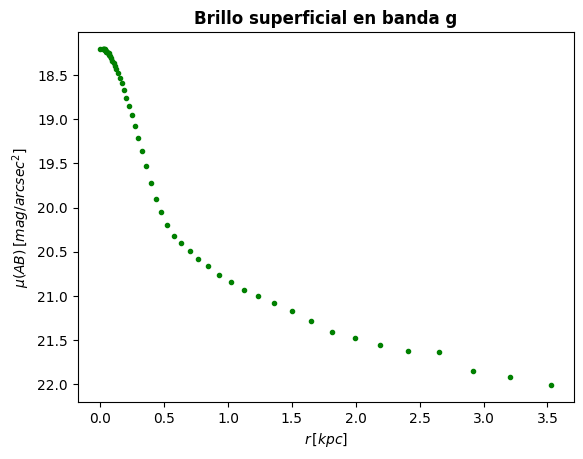

In [9]:
# Parámetros sma (semi-eje mayor en arcsec) e intens ((cuentas/pixel)^2)
sma_g = data_g['sma']
intens_g = data_g['intens']
t_exp_g = 688 # sacada del header NGC2543_panstarrs_g.fits
px_arcsec = 1 / 0.25 # sacado del guión

# Radio en pc
r_g = sma_g * 0.25 * 0.169 * 1000 #( * 1000 para pasar a pc)
u_AB_g = -2.5 * np.log10(intens_g * (px_arcsec)**2) + 2.5 * np.log10(t_exp_g) + 25

# Plot BRILLO SUPERFICIAL - banda g
plt.plot(r_g/1e3, u_AB_g, '.', color = 'green') # entre 1e3 para pasarlo a kpc
plt.title('Brillo superficial en banda g', fontweight = 'bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$\mu(AB)\,[mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.savefig('Images/brillo_superficial_banda_g.png')
plt.show()

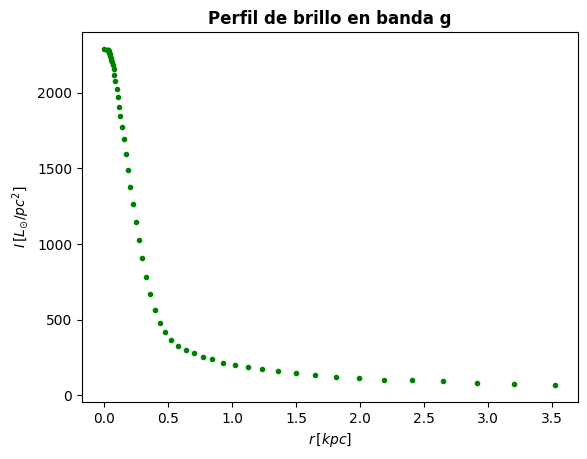

In [10]:
# Intensidad (luminosidad solar por pc cuadrado)
M_g = 5.03
I_g = 10 ** (- (u_AB_g - M_g - 21.572)/ 2.5)

# Plot PERFIL DE BRILLO - banda i
plt.plot(r_g/1e3, I_g, '.', color = 'green') # entre 1e3 para pasarlo a kpc
plt.title('Perfil de brillo en banda g', fontweight='bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$I\\,[L_{{\\odot}}/pc^2]$')
plt.savefig('Images/perfil_brillo_banda_g.png')
plt.show()

## 2. Curva de velocidad V(r) teórica

Según se nos dice en el guión, al curva de velocidad se puede ajustar por la siguiente expresión

$$
\begin{equation}
    V(r) = a\cdot tan^{-1}(br)
\end{equation}
$$

donde los valores de a y b se estiman a partir de los scripts.py (a $\simeq$ 135 y b $\simeq$ 1.21). Representemos entonces este función V(r). 

Nótese que r[arcsec] tiene unidades de arcsec lo que implica que b[arcsec$^{-1}$] tiene unidades de arcsec$^{-1}$ y a[km/s] de km/s. Además, hay utilizar un rango de valores de R[arcsec] entre 0 arcsec y 9.4866 arcsec, valor obtenido de los script.py. Su conversión sería por tanto, 

$$
\begin{equation}
    r[kpc] = r[arcsec] \cdot 0.169[kpc/arcsec].
\end{equation}
$$

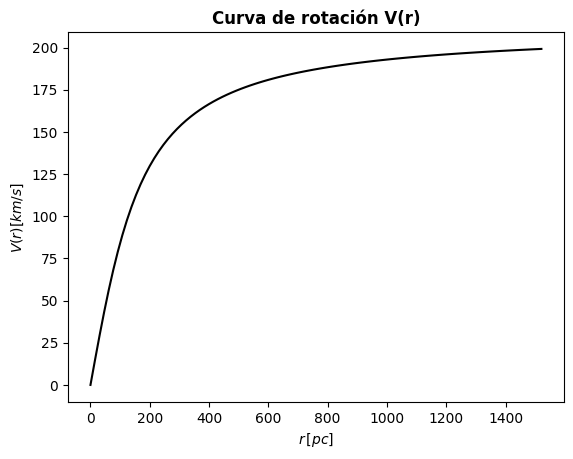

In [11]:
# Curva de velocidad V(R)
r_v_max = np.round(9.486635989107299) # valor máximo del radio para el ajuste de V(R) en arcsec
r_v_arcsec = np.linspace(0,r_v_max,100) # rango de valores de R en arcsec
r_v = np.linspace(0,r_v_max * 0.169,100) # rango de valores de R en Kpc
a = 134.59589 # km/s
b = 1.21900 # arcsec^{-1}
v_r_teo = a * np.arctan(b * r_v_arcsec) # velocidad circular teórica y entre 1e3 para pasarlo a kpc

plt.plot(r_v*1000, v_r_teo, color = 'black') # entre 1e3 para pasarlo a kpc
plt.title('Curva de rotación V(r)', fontweight='bold')
plt.xlabel(f'$r\,[pc]$')
plt.ylabel(f'$V(r) [km/s]$')
plt.savefig('Images/curva_V.png')
plt.show()

### Componentes de la velocidad

En la siguiente celda, definimos las funciones que describen las velocidades al cuadrado de las diferentes componentes de la galaxia junto a la total. Estas serán utilizadas en la _Sección 4_. 

In [12]:
# Velocidad del bulbo al cuadrado
def v2_bulbo(r, aries_bulbo):

    I0_bulbo = params_r[0] # 4190
    r0 = params_r[2] # 232.5

    M = 4 * np.pi * r0**3 * aries_bulbo * (I0_bulbo/(2*r0)) * (np.log(r/r0 + np.sqrt(1 + r**2/r0**2)) - r/r0 * (1 + r**2/r0**2)**(-1/2))

    return G*M/r

# Velocidad del disco al cuadrado
def v2_disco(r, aries_disco):

    I0_disco = params_r[1] # 201.3
    alpha = params_r[3] # 6977
    y = r/(2*alpha)

    return 4*np.pi*G * aries_disco * I0_disco * (iv(0,y)*kn(0,y) - iv(1,y)*kn(1,y)) * y**2 * alpha

# Velocidad del DM al cuadrado
def v2_DM(r, rho_s, r_s):

    return 4*np.pi*(1/232)*(1/r_filtered)*( (rho_s*r_s*r_filtered**2)/(r_filtered/r_s + 1)**2 )

# Velocidad total al cuadrado
def v_tot(r, aries_bulbo, aries_disco, rho_s, r_s):

    return np.sqrt(v2_DM(r, rho_s, r_s) + v2_disco(r, aries_disco) + v2_bulbo(r, aries_bulbo))

## 3. Ajustes a I[L$_{\odot}/pc^2$]

En esta sección, vamos a realizar el ajuste a I[L$_{\odot}/pc^2$] dada por la expresión,

$$
\begin{equation}
    I = I_{bulbo} + I_{disco} = \frac{I_{0, bulbo}}{1 + (r/r_0)^2} + I_{0, disco} \cdot e^{-r/\alpha}
\end{equation}
$$

donde los parámetros a ajustar (desconocidos) son $I_{0, bulbo}$[L$_{\odot}/pc^2$], $I_{0, disco}$[L$_{\odot}/pc^2$], $r_0$[pc] y $\alpha$[pc]. Para ello, emplearemos el comando `curve_fit`.

### 3.1. Banda r

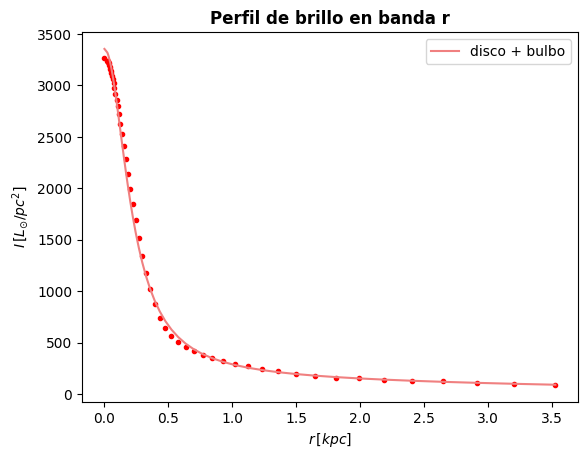

Parámetros ajustados:

I0_bulbo[Lsun/pc²]  = 3166.0 ± 37.0
I0_disco[Lsun/pc²]  = 188.0 ± 12.0
r0[pc]           = 217.0 ± 4.0
alpha[pc]        = 4102.0 ± 409.0


In [13]:
# Plot PERFIL DE BRILLO - banda r
plt.plot(r_r/1e3, I_r, '.', color = 'red')
plt.title('Perfil de brillo en banda r', fontweight='bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$I\\,[L_{{\\odot}}/pc^2]$')

# Fit: curve fit
def modelo_I(r, I0_bulbo, I0_disco, r0, alpha):
    return np.log10(I0_bulbo / (1 + (r/r0)**2) + I0_disco * np.exp(-r/alpha))
    
params_r, covariance_r = curve_fit(modelo_I, r_r, np.log10(I_r), p0 = [3000, 90, 25, 6000],method = 'trf', ftol=1e-6, xtol=1e-6)

I_fit_r = modelo_I(r_r, params_r[0], params_r[1], params_r[2], params_r[3])
plt.plot(r_r/1e3, 10**I_fit_r, color = 'lightcoral', label = 'disco + bulbo')
plt.legend()
plt.savefig('Images/ajuste_I_banda_r.png')
plt.show()

print('Parámetros ajustados:')
print('')
print('I0_bulbo[Lsun/pc²]  =', np.round(params_r[0]), '±', np.round(np.sqrt(np.diag(covariance_r))[0]))
print('I0_disco[Lsun/pc²]  =', np.round(params_r[1]), '±', np.round(np.sqrt(np.diag(covariance_r))[1]))
print('r0[pc]           =', np.round(params_r[2]), '±', np.round(np.sqrt(np.diag(covariance_r))[2]))
print('alpha[pc]        =', np.round(params_r[3]), '±', np.round(np.sqrt(np.diag(covariance_r))[3]))

### 3.2. Banda i

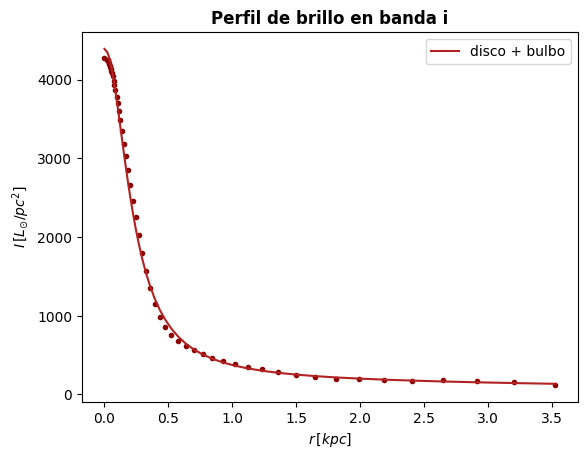

Parámetros ajustados:

I0_bulbo[Lsun/pc²]  = 4191.0 ± 55.0
I0_disco[Lsun/pc²]  = 201.0 ± 16.0
r0[pc]           = 225.0 ± 4.0
alpha[pc]        = 6690.0 ± 1331.0


In [14]:
# Plot PERFIL DE BRILLO - banda i
plt.plot(r_i/1e3, I_i, '.', color = 'darkred')
plt.title('Perfil de brillo en banda i', fontweight='bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$I\\,[L_{{\\odot}}/pc^2]$')

# Fit: curve fit
def modelo_I(r, I0_bulbo, I0_disco, r0, alpha):
    return np.log10(I0_bulbo / (1 + (r/r0)**2) + I0_disco * np.exp(-r/alpha))
    
params_i, covariance_i = curve_fit(modelo_I, r_i, np.log10(I_i), p0 = [3000, 90, 25, 6000],method = 'trf', ftol=1e-6, xtol=1e-6)

I_fit_i = modelo_I(r_i, params_i[0], params_i[1], params_i[2], params_i[3])
plt.plot(r_i/1e3, 10**I_fit_i, color = 'firebrick', label = 'disco + bulbo')
plt.legend()
plt.savefig('Images/ajuste_I_banda_i.png')
plt.show()

print('Parámetros ajustados:')
print('')
print('I0_bulbo[Lsun/pc²]  =', np.round(params_i[0]), '±', np.round(np.sqrt(np.diag(covariance_i))[0]))
print('I0_disco[Lsun/pc²]  =', np.round(params_i[1]), '±', np.round(np.sqrt(np.diag(covariance_i))[1]))
print('r0[pc]           =', np.round(params_i[2]), '±', np.round(np.sqrt(np.diag(covariance_i))[2]))
print('alpha[pc]        =', np.round(params_i[3]), '±', np.round(np.sqrt(np.diag(covariance_i))[3]))

### 3.3. Banda g

/tmp/ipykernel_9157/3335619759.py:9: RuntimeWarning: invalid value encountered in log10
  return np.log10(I0_bulbo / (1 + (r/r0)**2) + I0_disco * np.exp(-r/alpha))


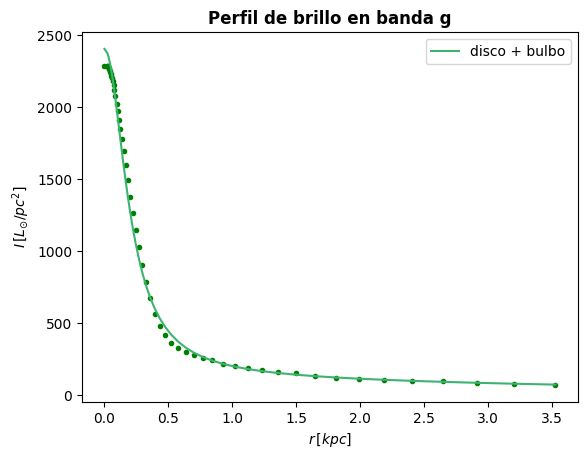

Parámetros ajustados:

I0_bulbo[Lsun/pc²]  = 2267.0 ± 34.0
I0_disco[Lsun/pc²]  = 138.0 ± 10.0
r0[pc]           = 202.0 ± 5.0
alpha[pc]        = 4540.0 ± 583.0


In [15]:
# Plot PERFIL DE BRILLO - banda g
plt.plot(r_g/1e3, I_g, '.', color = 'green')
plt.title('Perfil de brillo en banda g', fontweight='bold')
plt.xlabel(f'$r\,[kpc]$')
plt.ylabel(f'$I\\,[L_{{\\odot}}/pc^2]$')

# Fit: curve fit
def modelo_I(r, I0_bulbo, I0_disco, r0, alpha):
    return np.log10(I0_bulbo / (1 + (r/r0)**2) + I0_disco * np.exp(-r/alpha))
    
params_g, covariance_g = curve_fit(modelo_I, r_g, np.log10(I_g), p0 = [3000, 90, 25, 6000],method = 'trf', ftol=1e-6, xtol=1e-6)

I_fit_g = modelo_I(r_g, params_g[0], params_g[1], params_g[2], params_g[3])
plt.plot(r_g/1e3, 10**I_fit_g, color = 'mediumseagreen', label = 'disco + bulbo')
plt.legend()
plt.savefig('Images/ajuste_I_banda_g.png')
plt.show()

print('Parámetros ajustados:')
print('')
print('I0_bulbo[Lsun/pc²]  =', np.round(params_g[0]), '±', np.round(np.sqrt(np.diag(covariance_g))[0]))
print('I0_disco[Lsun/pc²]  =', np.round(params_g[1]), '±', np.round(np.sqrt(np.diag(covariance_g))[1]))
print('r0[pc]           =', np.round(params_g[2]), '±', np.round(np.sqrt(np.diag(covariance_g))[2]))
print('alpha[pc]        =', np.round(params_g[3]), '±', np.round(np.sqrt(np.diag(covariance_g))[3]))

## 4. Ajustes a V(R)

A continuación, realizamos otro ajuste utilizado `lmfit` (método es más exacto que el anterior) para la expresión para la velocidad circular V(R) dada por,

$$
\begin{equation}
    V(R) = \sqrt{v_{c, bulbo}^2 + v_{c, disco}^2 + v_{c, DM}^2}
\end{equation}
$$

donde $v_{c, bulbo}$, $v_{c, disco}$  y $v_{c, DM}$ dependen de ♈︎$_{disco}$, ♈︎$_{bulbo}$, $\rho_s$ y $r_s$, que son los parámetros a ajustar (desconocidos). Además, estas velocidades para cada componente de la galaxia dependen de los parámetros ya ajustados en I[L$_{\odot}/pc^2$] y funciones de Bessel que tendremos que importar. Nótese que los valores de V(R), necesarios de ser conocidos para realizar el ajuste, son los obtenidos en la Sección 2. 

### 4.1. Banda r

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 99
    # variables        = 4
    chi-square         = 164.809095
    reduced chi-square = 1.73483257
    Akaike info crit   = 58.4571272
    Bayesian info crit = 68.8376066
[[Variables]]
    aries_bulbo:  4.22722207 +/- 0.08559574 (2.02%) (init = 3)
    aries_disco:  4.98310637 +/- 1.04368446 (20.94%) (init = 10)
    rho_s:        0.14102238 +/- 0.03941745 (27.95%) (init = 0.9)
    r_s:          2566.39253 +/- 623.398455 (24.29%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_s, r_s)               = -0.9602
    C(aries_disco, r_s)         = -0.9511
    C(aries_disco, rho_s)       = +0.8301
    C(aries_bulbo, rho_s)       = -0.2867
    C(aries_bulbo, aries_disco) = +0.2633


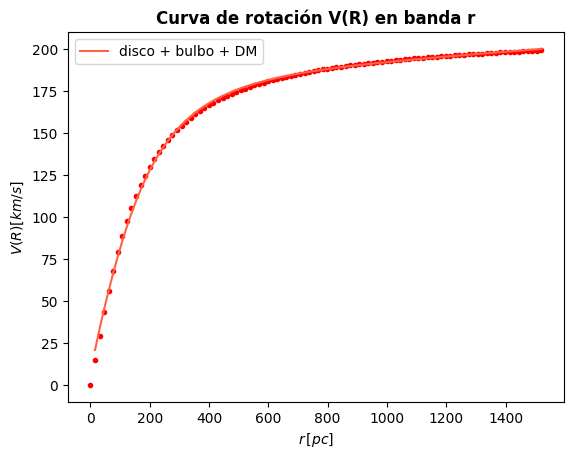

In [16]:
# Data
r = r_v * 1000; r_filtered = r[1:len(r)]
v_r_teo = a * np.arctan(b * r_v_arcsec); v_r_teo_filtered = v_r_teo[1:len(v_r_teo)]

# Parámetros iniciales
fit_params = lmfit.create_params(aries_bulbo = {'value': 3., 'min': 0.1, 'max': 100},
                                 aries_disco = {'value':10, 'min': 0.1, 'max': 100},
                                 rho_s = {'value': 0.9, 'min': 0.1, 'max': 10},
                                     r_s = {'value': 500, 'min': 200, 'max': 3000})

# Curva de velocidad
def myfit(params, r_filtered, v_r_teo_filtered, someflag = True):

    aries_bulbo = params['aries_bulbo'].value
    aries_disco = params['aries_disco'].value
    rho_s = params['rho_s'].value
    r_s = params['r_s'].value

    # Parámetros obtenidos del ajusta a I
    I0_bulbo = params_r[0]
    I0_disco = params_r[1]
    r0 = params_r[2]
    alpha = params_r[3]
    y = r_filtered/(2*alpha)

    # Masa del bulbo
    M = 4 * np.pi * r0**3 * aries_bulbo * (I0_bulbo/(2*r0)) * (np.log(r_filtered/r0 + np.sqrt(1 + r_filtered**2/r0**2)) - r_filtered/r0 * (1 + r_filtered**2/r0**2)**(-1/2))

    
    # Velocidades de las componentes
    v2_bulbo = G*M/r_filtered
    v2_disco = 4*np.pi*G * aries_disco * I0_disco * (iv(0,y)*kn(0,y) - iv(1,y)*kn(1,y)) * y**2 * alpha
    v2_DM = 4*np.pi*(1/232)*(1/r_filtered)*( (rho_s*r_s*r_filtered**2)/(r_filtered/r_s + 1)**2 )
    
    # Modelo
    model = np.sqrt(v2_bulbo + v2_disco + v2_DM) # np.sqrt(v2_bulbo + v2_disco + v2_DM)
    
    return model - v_r_teo_filtered

# Fitting
result_r = lmfit.minimize(myfit, fit_params, args = (r_filtered, v_r_teo_filtered))
lmfit.report_fit(result_r)

# Plots 
plt.plot(r, v_r_teo, '.', color = 'red') # entre 1e3 para pasarlo a kpc
plt.plot(r_filtered, v_r_teo_filtered + result_r.residual, label='disco + bulbo + DM', color='tomato') # fit

plt.title('Curva de rotación V(R) en banda r', fontweight='bold')
plt.xlabel(f'$r\,[pc]$')
plt.ylabel(f'$V(R) [km/s]$')
plt.legend()
plt.savefig('Images/ajuste_V_banda_r.png')
plt.show()

In [17]:
print('Parámetros ajustados:')
print('')
print('aries_bulbo[Lsun/Msun]  =', np.round(result_r.params['aries_disco'].value,2), '±', np.round(result_r.params['aries_disco'].stderr,2))
print('aries_disco[Lsun/Msun]  =', np.round(result_r.params['aries_bulbo'].value,2), '±', np.round(result_r.params['aries_bulbo'].stderr,2))
print('rho_s[pc⁻¹]           =', np.round(result_r.params['rho_s'].value,2), '±', np.round(result_r.params['rho_s'].stderr,2))
print('r_s[pc]        =', np.round(result_r.params['r_s'].value), '±', np.round(result_r.params['r_s'].stderr))

Parámetros ajustados:

aries_bulbo[Lsun/Msun]  = 4.98 ± 1.04
aries_disco[Lsun/Msun]  = 4.23 ± 0.09
rho_s[pc⁻¹]           = 0.14 ± 0.04
r_s[pc]        = 2566.0 ± 623.0


### 4.2. Banda i

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 99
    # variables        = 4
    chi-square         = 223.670159
    reduced chi-square = 2.35442272
    Akaike info crit   = 88.6902084
    Bayesian info crit = 99.0706878
[[Variables]]
    aries_bulbo:  3.10781746 +/- 0.07596344 (2.44%) (init = 3)
    aries_disco:  6.85655807 +/- 0.69045982 (10.07%) (init = 10)
    rho_s:        0.25537743 +/- 0.04117520 (16.12%) (init = 0.9)
    r_s:          1658.17496 +/- 219.145361 (13.22%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(aries_disco, r_s)         = -0.9342
    C(rho_s, r_s)               = -0.8683
    C(aries_disco, rho_s)       = +0.6561
    C(aries_bulbo, aries_disco) = +0.5592
    C(aries_bulbo, r_s)         = -0.3172
    C(aries_bulbo, rho_s)       = -0.1848


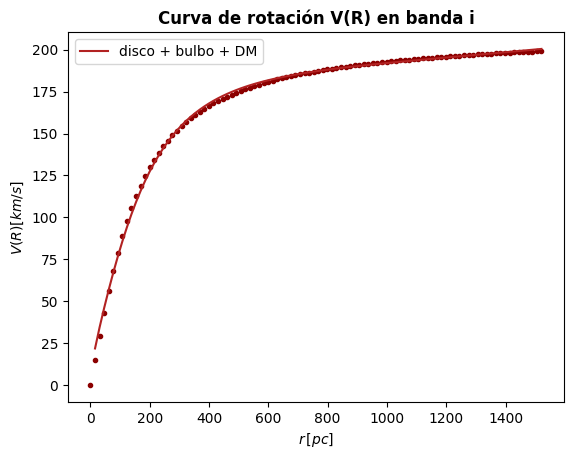

In [18]:
# Data
r = r_v * 1000; r_filtered = r[1:len(r)]
v_r_teo = a * np.arctan(b * r_v_arcsec); v_r_teo_filtered = v_r_teo[1:len(v_r_teo)]

# Parámetros iniciales
fit_params = lmfit.create_params(aries_bulbo = {'value': 3., 'min': 0.1, 'max': 100},
                                 aries_disco = {'value':10, 'min': 0.1, 'max': 100},
                                 rho_s = {'value': 0.9, 'min': 0.1, 'max': 10},
                                     r_s = {'value': 500, 'min': 200, 'max': 3000})

# Curva de velocidad
def myfit(params, r_filtered, v_r_teo_filtered, someflag = True):

    aries_bulbo = params['aries_bulbo'].value
    aries_disco = params['aries_disco'].value
    rho_s = params['rho_s'].value
    r_s = params['r_s'].value

    # Parámetros obtenidos del ajusta a I
    I0_bulbo = params_i[0]
    I0_disco = params_i[1]
    r0 = params_i[2]
    alpha = params_i[3]
    y = r_filtered/(2*alpha)

    # Masa del bulbo
    M = 4 * np.pi * r0**3 * aries_bulbo * (I0_bulbo/(2*r0)) * (np.log(r_filtered/r0 + np.sqrt(1 + r_filtered**2/r0**2)) - r_filtered/r0 * (1 + r_filtered**2/r0**2)**(-1/2))

    
    # Velocidades de las componentes
    v2_bulbo = G*M/r_filtered
    v2_disco = 4*np.pi*G * aries_disco * I0_disco * (iv(0,y)*kn(0,y) - iv(1,y)*kn(1,y)) * y**2 * alpha
    v2_DM = 4*np.pi*(1/232)*(1/r_filtered)*( (rho_s*r_s*r_filtered**2)/(r_filtered/r_s + 1)**2 )
    
    # Modelo
    model = np.sqrt(v2_bulbo + v2_disco + v2_DM) # np.sqrt(v2_bulbo + v2_disco + v2_DM)
    
    return model - v_r_teo_filtered

# Fitting
result_i = lmfit.minimize(myfit, fit_params, args = (r_filtered, v_r_teo_filtered))
lmfit.report_fit(result_i)

# Plots 
plt.plot(r, v_r_teo, '.', color = 'darkred') # entre 1e3 para pasarlo a kpc
plt.plot(r_filtered, v_r_teo_filtered + result_i.residual, label='disco + bulbo + DM', color='firebrick') # fit

plt.title('Curva de rotación V(R) en banda i', fontweight='bold')
plt.xlabel(f'$r\,[pc]$')
plt.ylabel(f'$V(R) [km/s]$')
plt.legend()
plt.savefig('Images/ajuste_V_banda_i.png')
plt.show()

In [19]:
print('Parámetros ajustados:')
print('')
print('aries_bulbo[Lsun/Msun]  =', np.round(result_i.params['aries_bulbo'].value,2), '±', np.round(result_i.params['aries_bulbo'].stderr,2))
print('aries_disco[Lsun/Msun]  =', np.round(result_i.params['aries_disco'].value,2), '±', np.round(result_i.params['aries_disco'].stderr,2))
print('rho_s[pc⁻¹]           =', np.round(result_i.params['rho_s'].value,2), '±', np.round(result_i.params['rho_s'].stderr,2))
print('r_s[pc]        =', np.round(result_i.params['r_s'].value), '±', np.round(result_i.params['r_s'].stderr))

Parámetros ajustados:

aries_bulbo[Lsun/Msun]  = 3.11 ± 0.08
aries_disco[Lsun/Msun]  = 6.86 ± 0.69
rho_s[pc⁻¹]           = 0.26 ± 0.04
r_s[pc]        = 1658.0 ± 219.0


### 4.3. banda g

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 99
    # variables        = 4
    chi-square         = 142.078614
    reduced chi-square = 1.49556436
    Akaike info crit   = 43.7648067
    Bayesian info crit = 54.1452861
[[Variables]]
    aries_bulbo:  6.05031244 +/- 0.21889673 (3.62%) (init = 3)
    aries_disco:  3.03932694 +/- 31.4636957 (1035.22%) (init = 10)
    rho_s:        0.06496156 +/- 0.34351305 (528.79%) (init = 0.9)
    r_s:          5678.21289 +/- 30149.5354 (530.97%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_s, r_s)               = -0.9999
    C(aries_disco, r_s)         = -0.9997
    C(aries_disco, rho_s)       = +0.9993
    C(aries_bulbo, rho_s)       = -0.8664
    C(aries_bulbo, r_s)         = +0.8601
    C(aries_bulbo, aries_disco) = -0.8484


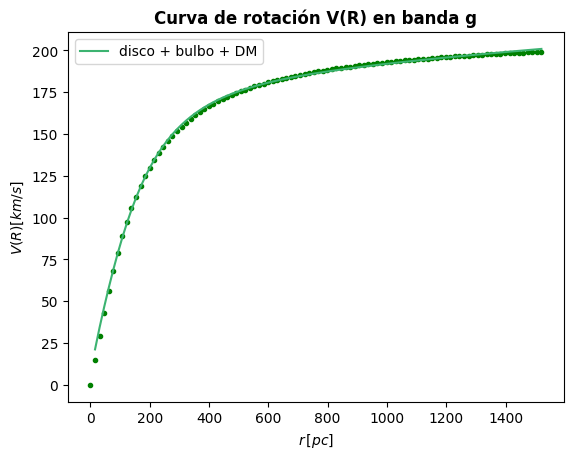

In [20]:
# Data
r = r_v * 1000; r_filtered = r[1:len(r)]
v_r_teo = a * np.arctan(b * r_v_arcsec); v_r_teo_filtered = v_r_teo[1:len(v_r_teo)]

# Parámetros iniciales
fit_params = lmfit.create_params(aries_bulbo = {'value': 3., 'min': 0.1, 'max': 200},
                                 aries_disco = {'value':10, 'min': 0.1, 'max': 200},
                                 rho_s = {'value': 0.9, 'min': 0.01, 'max': 20},
                                     r_s = {'value': 500, 'min': 200, 'max': 60000})

# Curva de velocidad
def myfit(params, r_filtered, v_r_teo_filtered, someflag = True):

    aries_bulbo = params['aries_bulbo'].value
    aries_disco = params['aries_disco'].value
    rho_s = params['rho_s'].value
    r_s = params['r_s'].value

    # Parámetros obtenidos del ajusta a I
    I0_bulbo = params_g[0]
    I0_disco = params_g[1]
    r0 = params_g[2]
    alpha = params_g[3]
    y = r_filtered/(2*alpha)

    # Masa del bulbo
    M = 4 * np.pi * r0**3 * aries_bulbo * (I0_bulbo/(2*r0)) * (np.log(r_filtered/r0 + np.sqrt(1 + r_filtered**2/r0**2)) - r_filtered/r0 * (1 + r_filtered**2/r0**2)**(-1/2))

    
    # Velocidades de las componentes
    v2_bulbo = G*M/r_filtered
    v2_disco = 4*np.pi*G * aries_disco * I0_disco * (iv(0,y)*kn(0,y) - iv(1,y)*kn(1,y)) * y**2 * alpha
    v2_DM = 4*np.pi*(1/232)*(1/r_filtered)*( (rho_s*r_s*r_filtered**2)/(r_filtered/r_s + 1)**2 )
    
    # Modelo
    model = np.sqrt(v2_bulbo + v2_disco + v2_DM) # np.sqrt(v2_bulbo + v2_disco + v2_DM)
    
    return model - v_r_teo_filtered

# Fitting
result_g = lmfit.minimize(myfit, fit_params, args = (r_filtered, v_r_teo_filtered))
lmfit.report_fit(result_g)

# Plots 
plt.plot(r, v_r_teo, '.', color = 'green') # entre 1e3 para pasarlo a kpc
plt.plot(r_filtered, v_r_teo_filtered + result_g.residual, label='disco + bulbo + DM', color='mediumseagreen') # fit

plt.title('Curva de rotación V(R) en banda g', fontweight='bold')
plt.xlabel(f'$r\,[pc]$')
plt.ylabel(f'$V(R) [km/s]$')
plt.legend()
plt.savefig('Images/ajuste_V_banda_g.png')
plt.show()

In [21]:
print('Parámetros ajustados:')
print('')
print('aries_bulbo[Lsun/Msun]  =', np.round(result_g.params['aries_bulbo'].value,2), '±', np.round(result_g.params['aries_bulbo'].stderr,2))
print('aries_disco[Lsun/Msun]  =', np.round(result_g.params['aries_disco'].value,2), '±', np.round(result_g.params['aries_disco'].stderr,2))
print('rho_s[pc⁻¹]           =', np.round(result_g.params['rho_s'].value,2), '±', np.round(result_g.params['rho_s'].stderr,2))
print('r_s[pc]        =', np.round(result_g.params['r_s'].value), '±', np.round(result_g.params['r_s'].stderr))

Parámetros ajustados:

aries_bulbo[Lsun/Msun]  = 6.05 ± 0.22
aries_disco[Lsun/Msun]  = 3.04 ± 31.46
rho_s[pc⁻¹]           = 0.06 ± 0.34
r_s[pc]        = 5678.0 ± 30150.0


## Curva de velocidad V(R) empírica

Por último, vamos a representar por separado y en su conjunto las diferentes componentes de la curva de rotación. Esto quiere decir que, a partir de los paŕametros de la curva estimados en la sección anterior, representaremos la componente de la velocidad del bulbo, del disco, de la materia osucra y todo su conjunto. Representaremos esta curva para las diferentes bandas.

### Banda r

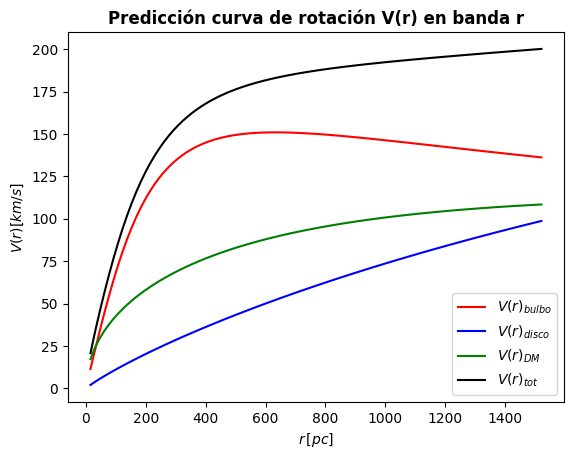

In [22]:
# Plot componente: bulbo
plt.plot(r_filtered, np.sqrt(v2_bulbo(r_filtered, result_r.params['aries_bulbo'].value)), color = 'red', label = r'$V(r)_{bulbo}$')

# Plot componente: disco
plt.plot(r_filtered, np.sqrt(v2_disco(r_filtered, result_r.params['aries_disco'].value)), color = 'blue', label = r'$V(r)_{disco}$')

# Plot componente: DM
plt.plot(r_filtered, np.sqrt(v2_DM(r_filtered, result_r.params['rho_s'].value, result_r.params['r_s'].value)), color = 'green', label = r'$V(r)_{DM}$')

# Plot componente: total
plt.plot(r_filtered, v_tot(r_filtered, result_r.params['aries_bulbo'].value, result_r.params['aries_disco'].value, result_r.params['rho_s'].value, result_r.params['r_s'].value), color = 'black', label = r'$V(r)_{tot}$')

plt.title('Predicción curva de rotación V(r) en banda r', fontweight='bold')
plt.xlabel(f'$r\,[pc]$')
plt.ylabel(f'$V(r) [km/s]$')
plt.legend()
plt.savefig('Images/componentes_V_banda_r.png')
plt.show()

### Banda i

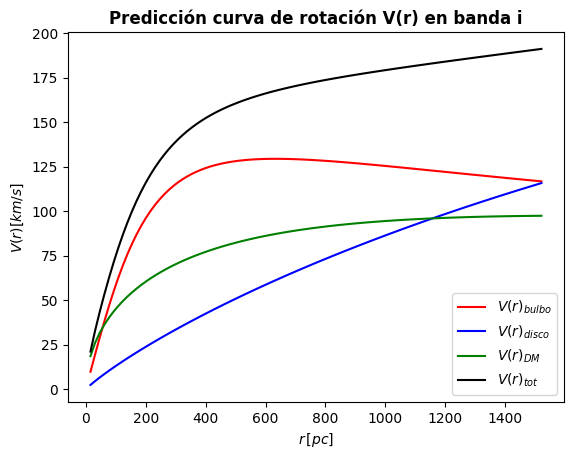

In [23]:
# Plot componente: bulbo
plt.plot(r_filtered, np.sqrt(v2_bulbo(r_filtered, result_i.params['aries_bulbo'].value)), color = 'red', label = r'$V(r)_{bulbo}$')

# Plot componente: disco
plt.plot(r_filtered, np.sqrt(v2_disco(r_filtered, result_i.params['aries_disco'].value)), color = 'blue', label = r'$V(r)_{disco}$')

# Plot componente: DM
plt.plot(r_filtered, np.sqrt(v2_DM(r_filtered, result_i.params['rho_s'].value, result_i.params['r_s'].value)), color = 'green', label = r'$V(r)_{DM}$')

# Plot componente: total
plt.plot(r_filtered, v_tot(r_filtered, result_i.params['aries_bulbo'].value, result_i.params['aries_disco'].value, result_i.params['rho_s'].value, result_i.params['r_s'].value), color = 'black', label = r'$V(r)_{tot}$')

plt.title('Predicción curva de rotación V(r) en banda i', fontweight='bold')
plt.xlabel(f'$r\,[pc]$')
plt.ylabel(f'$V(r) [km/s]$')
plt.legend()
plt.savefig('Images/componentes_V_banda_i.png')
plt.show()

### Banda g

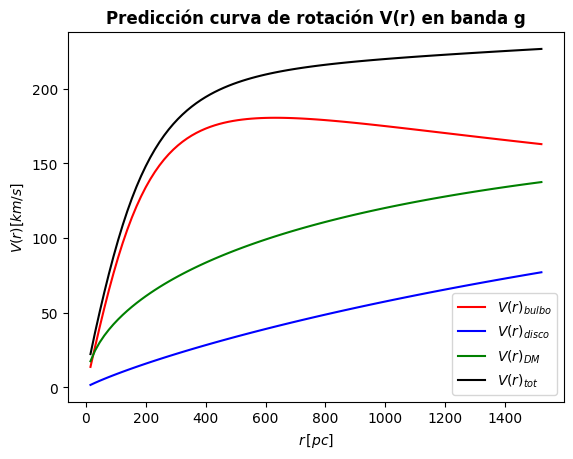

In [24]:
# Plot componente: bulbo
plt.plot(r_filtered, np.sqrt(v2_bulbo(r_filtered, result_g.params['aries_bulbo'].value)), color = 'red', label = r'$V(r)_{bulbo}$')

# Plot componente: disco
plt.plot(r_filtered, np.sqrt(v2_disco(r_filtered, result_g.params['aries_disco'].value)), color = 'blue', label = r'$V(r)_{disco}$')

# Plot componente: DM
plt.plot(r_filtered, np.sqrt(v2_DM(r_filtered, result_g.params['rho_s'].value, result_g.params['r_s'].value)), color = 'green', label = r'$V(r)_{DM}$')

# Plot componente: total
plt.plot(r_filtered, v_tot(r_filtered, result_g.params['aries_bulbo'].value, result_g.params['aries_disco'].value, result_g.params['rho_s'].value, result_g.params['r_s'].value), color = 'black', label = r'$V(r)_{tot}$')

plt.title('Predicción curva de rotación V(r) en banda g', fontweight='bold')
plt.xlabel(f'$r\,[pc]$')
plt.ylabel(f'$V(r) [km/s]$')
plt.legend()
plt.savefig('Images/componentes_V_banda_g.png')
plt.show()